<a href="https://colab.research.google.com/github/Jahan08/Model-interpretation/blob/main/In_House_Solubility_Fingerprints_and_classification_similarity_map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fingerprints and Classification

##### Nikolas Fechner
##### Novartis Institutes for BioMedical Research, Novartis Campus, 4002 Basel, Switzerland

In [2]:
%pylab inline
import pandas as pd
import sklearn
from rdkit import rdBase
import matplotlib as mpl
import numpy as np
import seaborn as sns
print('RDKit version: ',rdBase.rdkitVersion)
print('Pandas version:', pd.__version__)
print('Scikit-Learn version:', sklearn.__version__)
print('Numpy version:', np.__version__)
print('MatplotLib version:', mpl.__version__)
print('Seaborn version',sns.__version__)

Populating the interactive namespace from numpy and matplotlib
RDKit version:  2023.03.3
Pandas version: 1.5.3
Scikit-Learn version: 1.2.2
Numpy version: 1.23.5
MatplotLib version: 3.7.1
Seaborn version 0.12.2


## Dataset

Publicly available binary Ames test (mutagenicity) data compiled in "Benchmark Data Set for in Silico Prediction of Ames Mutagenicity", Katja Hansen et al., JCIM, 2009, 49(9),pp 2077-2081

Data available from http://doc.ml.tu-berlin.de/toxbenchmark/smiles_cas_N6512.smi

In [25]:
traindata = pd.read_csv('/content/Solubility-SRI-5-25-in-train.csv')
traindata.head()

,SRI Number,Smiles,Solubility_uM,Sol,LogS,Solubility
0,SRI-00037013,c1(c(cccc2)c2c(nnc3C)n3n1)c4ccc(C)c(C(=O)N5CCC...,315.2,Yes,-3.501414,1
1,SRI-00040374,c1ccc(n(C(=O)N)nc2c3ccccc3)c2c1CN,308.3,Yes,-3.511026,1
2,SRI-00037011,c1(c(cccc2)c2c(nnc3C)n3n1)c4ccc(C)c(C(N(C)C)=O)c4,300.6,Yes,-3.522011,1
3,SRI-00039996,N1(C(=O)N(C)C(=O)C(C(CN(C(C)C)CC(N)=O)=O)=C1N)C,300.0,Yes,-3.522879,1
4,SRI-00038182,c1(c(F)cc(ncnc2N3CC(CNS(=O)(=O)C)CCC3)c2c1)C#N,298.3,Yes,-3.525347,1


As real-valued descriptors have been covered in the last example, this one will be using fingerprints. For scikit-learn we do need standard python/numpy collections, thus the ExplicitBitVect objects returm by RDKit have to be coverted first.

Returning 'None' in the case of an error allows for simple post-filtering with pandas.

In [26]:
testdata = pd.read_csv('/content/Solubility-SRI-5-25-in-test.csv')
testdata.head()

,SRI Number,Smiles,Solubility_uM,Sol,LogS,Solubility
0,SRI-00040373,c1ccc([nH]nc2c3ccccc3)c2c1CN,316.3,Yes,-3.499901,1
1,SRI-00037330,C(c1ccc(ncnc2N3CCCC(CNS(=O)(=O)C)C3)c2c1)(F)(F)F,300.0,Yes,-3.522879,1
2,SRI-00045893,c1(C(=O)NC(N2CCN(C(c3c(O)ccc(F)c3)=O)CC2)=N4)c...,276.3,Yes,-3.558619,1
3,SRI-00039984,N1(C(=O)N(Cc2ccccc2)C(N)=C(C(CN3[C@H](C(=O)OC)...,261.3,Yes,-3.582861,1
4,SRI-00039764,C1(N(Cc2ccccc2)C(N)=C(C(=O)CN3CCCC3C(OC)=O)C(=...,259.7,Yes,-3.585528,1


In [27]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools
from rdkit import DataStructs

def computeMorganFP(mol, depth=2, nBits=2048):
    a = np.zeros(nBits)
    try:
      DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol,depth,nBits),a)
    except:
      return None
    return a

def computeRDKitFP(mol, maxLength=7, nBits=2048):
    a = np.zeros(nBits)
    try:
      DataStructs.ConvertToNumpyArray(Chem.RDKFingerprint(mol,maxPath=maxLength, fpSize=nBits),a)
    except:
      return None
    return a


However, first we have to get rid of a couple of problematic smiles:

In [30]:
PandasTools.AddMoleculeColumnToFrame(frame=traindata, smilesCol='Smiles', molCol='Molecule')
problematicSmiles = traindata.loc[traindata['Molecule'].map(lambda x: x is None)]
problematicSmiles

,SRI Number,Smiles,Solubility_uM,Sol,LogS,Solubility,Molecule


In [31]:
PandasTools.AddMoleculeColumnToFrame(frame=testdata, smilesCol='Smiles', molCol='Molecule')
problematicSmiles = testdata.loc[testdata['Molecule'].map(lambda x: x is None)]
problematicSmiles

,SRI Number,Smiles,Solubility_uM,Sol,LogS,Solubility,Molecule


In [32]:
traindata = traindata.loc[traindata['Molecule'].map(lambda x: x is not None)]

6506 compounds left for modelling. Given that we have [0,1]-class labels the "mean" of 0.54 corresponds to the fraction of '1's in the data. Hence the classes or fairly balanced, which is beneficial for all kinds of classification algorithms.

In [33]:
traindata.describe()

,Solubility_uM,LogS,Solubility
count,2114.000000,2114.000000,2114.000000
mean,33.440649,-5.102843,0.485336
std,41.868209,0.898342,0.499903
min,0.001000,-9.000000,0.000000
25%,1.000000,-6.000000,0.000000
50%,3.900000,-5.408935,0.000000
75%,63.600000,-4.196543,1.000000
max,315.200000,-3.501414,1.000000


In [34]:
testdata = testdata.loc[testdata['Molecule'].map(lambda x: x is not None)]

In [35]:
testdata.describe()

,Solubility_uM,LogS,Solubility
count,539.000000,539.000000,539.000000
mean,34.437519,-5.117333,0.478664
std,43.908931,0.938852,0.500009
min,0.001000,-9.000000,0.000000
25%,1.000000,-6.000000,0.000000
50%,3.800000,-5.420216,0.000000
75%,65.300000,-4.185087,1.000000
max,316.300000,-3.499901,1.000000


In [36]:
traindata['Morgan2FP'] = traindata['Molecule'].map(computeMorganFP)
traindata['RDKit7FP'] = traindata['Molecule'].map(computeRDKitFP)

In [37]:
testdata['Morgan2FP'] = testdata['Molecule'].map(computeMorganFP)
testdata['RDKit7FP'] = testdata['Molecule'].map(computeRDKitFP)

In the first example, a simple Bernoulli Naive Bayes model is created and evaluated regarding its categorical prediction accuracy.

In [38]:
def confusion_matrix_summary(acts,preds):
    '''Simple classification evaluation based on discrete, exact class comparison'''
    from io import StringIO
    file_str = StringIO()
    vTab=metrics.confusion_matrix(acts,preds)
    #print vTab
    nResultCodes=len(vTab)
    file_str.write('\n\tResults Table (experiment in rows):\n')
    colCounts = np.sum(vTab,0)
    rowCounts = np.sum(vTab,1)
    print
    for i in range(nResultCodes):
        if rowCounts[i]==0: rowCounts[i]=1
        row = vTab[i]
        file_str.write('    ')
        for j in range(nResultCodes):
            entry = row[j]
            file_str.write(' % 6d'%entry),
        file_str.write('     | % 4.2f\n'%(100.*vTab[i,i]/rowCounts[i]))
    file_str.write('    ')
    for i in range(nResultCodes):
        file_str.write('-------')
    file_str.write('\n')
    file_str.write('    '),
    for i in range(nResultCodes):
        if colCounts[i]==0: colCounts[i]=1
        file_str.write(' % 6.2f'%(100.*vTab[i,i]/colCounts[i])),
    file_str.write('\n')
    return file_str.getvalue()

In [39]:
def createROCPlot(pl,observations,probabilities,caption):
    '''Create an ROC curve'''
    fpr, tpr, thresholds = metrics.roc_curve(observations, probabilities)
    roc_auc = metrics.auc(fpr, tpr)
    print("Area under the ROC curve : ",roc_auc)
    pl.plot(fpr, tpr, label='ROC curve (area = {0})'.format(roc_auc))
    pl.plot([0, 1], [0, 1], 'k--')
    pl.set_xlim([0.0, 1.0])
    pl.set_ylim([0.0, 1.0])
    pl.set_xlabel('False Positive Rate')
    pl.set_ylabel('True Positive Rate')
    pl.set_title(caption)

In [41]:
def createPRPlot(pl,observations,probabilities,caption):
    '''Create a Precision/Recall Curve'''
    prec, rec, thresholds = metrics.precision_recall_curve(observations, probabilities)
    accuracies = []
    pl.plot(prec, rec, label='Recision/Recall')
    pl.plot([0, 1], [0, 1], 'k--')
    pl.set_xlim([0.0, 1.0])
    pl.set_ylim([0.0, 1.0])
    pl.set_xlabel('Precision')
    pl.set_ylabel('Recall')
    pl.set_title(caption)

In [42]:
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics
morgan_bnb = BernoulliNB(fit_prior=False)
morgan_bnb.fit(list(traindata['Morgan2FP']),traindata['Solubility'])
morgan_predictions = morgan_bnb.predict(list(testdata['Morgan2FP']))
print('Morgan Fingerprints')
print(confusion_matrix_summary(testdata['Solubility'],morgan_predictions))
print( metrics.classification_report(testdata['Solubility'],morgan_predictions))


print('------------------------------------------------------------')

rd_bnb = BernoulliNB(fit_prior=False)
rd_bnb.fit(list(traindata['RDKit7FP']),traindata['Solubility'])
rd_predictions = rd_bnb.predict(list(testdata['RDKit7FP']))
print('RDKit Fingerprints')
print(confusion_matrix_summary(testdata['Solubility'],rd_predictions))
print( metrics.classification_report(testdata['Solubility'],rd_predictions))


morgan_probabilities = [p[1] for p in morgan_bnb.predict_proba(list(testdata['Morgan2FP']))]
rd_probabilities = [p[1] for p in rd_bnb.predict_proba(list(testdata['RDKit7FP']))]

Morgan Fingerprints

	Results Table (experiment in rows):
        232     49     |  82.56
         79    179     |  69.38
    --------------
      74.60  78.51

              precision    recall  f1-score   support

           0       0.75      0.83      0.78       281
           1       0.79      0.69      0.74       258

    accuracy                           0.76       539
   macro avg       0.77      0.76      0.76       539
weighted avg       0.76      0.76      0.76       539

------------------------------------------------------------
RDKit Fingerprints

	Results Table (experiment in rows):
        214     67     |  76.16
         67    191     |  74.03
    --------------
      76.16  74.03

              precision    recall  f1-score   support

           0       0.76      0.76      0.76       281
           1       0.74      0.74      0.74       258

    accuracy                           0.75       539
   macro avg       0.75      0.75      0.75       539
weighted avg       

The simple classification evaluation assumes that a sample is assigned to either one or the other class, ignoring any degree of uncertainty. However, in many cases there are actually quantitative estimates used for this decision (e.g. class probabilities) and the predicted class is simply the one with the largest score.

While in the current, fairly balanced example this approach might lead to reasonable results, in other scenarios a more detailed evaluation of the quantitative estimates might make sense. This is especially true if either the classes themself are unbalanced, or the risk of a misclassification is assymetrical.

In such situations, ROC or Precision/Recall curves are useful tools to get a more detailed evaluation.

In [43]:
import matplotlib.pyplot as plt

Area under the ROC curve :  0.8384783028497339
Area under the ROC curve :  0.8064153493889488


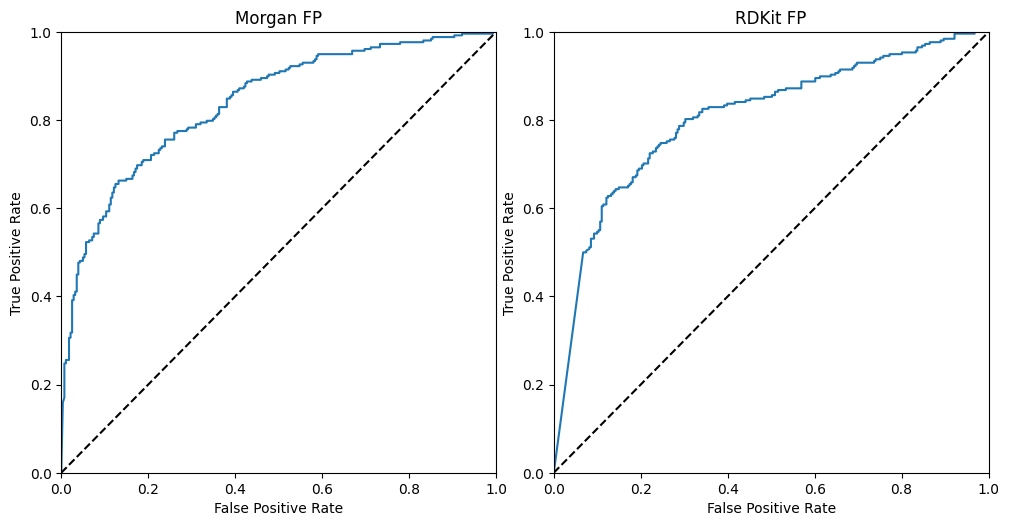

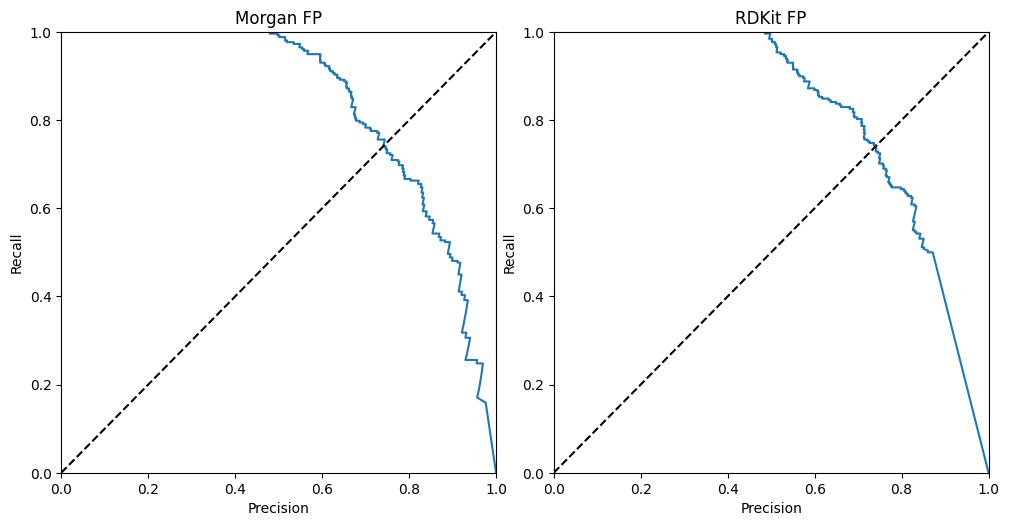

In [44]:
figure,(ax1,ax2) = plt.subplots(1,2)
figure.set_size_inches(10,5)
figure.tight_layout()

createROCPlot(ax1,testdata['Solubility'],morgan_probabilities,'Morgan FP')
createROCPlot(ax2,testdata['Solubility'],rd_probabilities,'RDKit FP')

figure,(ax1,ax2) = plt.subplots(1,2)
figure.set_size_inches(10,5)
figure.tight_layout()

createPRPlot(ax1,testdata['Solubility'],morgan_probabilities,'Morgan FP')
createPRPlot(ax2,testdata['Solubility'],rd_probabilities,'RDKit FP')



As with regression, there are many different machine learning algorithms available for classification as well. One of the most versatile and robust approach is a Random Forest. However, it has a significant number of parameters and is also quite sensitive to different parameterization. Consequently, wrapping this in an automated grid search makes sense.

In [49]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
params = {'max_depth':[5,10,20],'min_samples_split':[2,8,32],'min_samples_leaf':[1,2,5,10],'n_estimators':[50,100,200]}
cv=StratifiedKFold(n_splits= 5, shuffle=True)
#cv = KFold(n=len(traindata),n_folds=10,shuffle=True)
gs = GridSearchCV(RandomForestClassifier(), params, cv=cv,verbose=1,refit=True)
gs.fit(list(traindata['Morgan2FP']), traindata['Solubility'])

print('Best score: %0.2f',gs.best_score_)
print('Training set performance using best parameters (%s)', gs.best_params_)
best_morgan_treemodel = gs.best_estimator_
#training set evaluation
best_morgan_tree_prediction = best_morgan_treemodel.predict(list(testdata['Morgan2FP']))
print('Morgan Fingerprints')
print(confusion_matrix_summary(testdata['Solubility'],best_morgan_tree_prediction))
print( metrics.classification_report(testdata['Solubility'],best_morgan_tree_prediction))


print('------------------------------------------------------------')
gs.fit(list(traindata['RDKit7FP']), traindata['Solubility'])
print('Best score: %0.2f',gs.best_score_)
print('Training set performance using best parameters (%s)', gs.best_params_)
best_rd_treemodel = gs.best_estimator_
#training set evaluation
best_rd_tree_prediction = best_rd_treemodel.predict(list(testdata['RDKit7FP']))
print('RDKit Fingerprints')
print(confusion_matrix_summary(testdata['Solubility'],best_rd_tree_prediction))
print( metrics.classification_report(testdata['Solubility'],best_rd_tree_prediction))



Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best score: %0.2f 0.7994386743302746
Training set performance using best parameters (%s) {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Morgan Fingerprints

	Results Table (experiment in rows):
        230     51     |  81.85
         53    205     |  79.46
    --------------
      81.27  80.08

              precision    recall  f1-score   support

           0       0.81      0.82      0.82       281
           1       0.80      0.79      0.80       258

    accuracy                           0.81       539
   macro avg       0.81      0.81      0.81       539
weighted avg       0.81      0.81      0.81       539

------------------------------------------------------------
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best score: %0.2f 0.8046295362620863
Training set performance using best parameters (%s) {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split':

In [50]:
print(best_morgan_treemodel)
print(best_rd_treemodel)

RandomForestClassifier(max_depth=20)
RandomForestClassifier(max_depth=20, min_samples_split=8, n_estimators=200)


Interesting, while with Naive Bayes the Morgan2 fingerprint gave - probably significantly - better models, the Random Forest does seem to be able to use the information from both fingerprints comparably well and better than Naive Bayes.

Area under the ROC curve :  0.8891555629120802
Area under the ROC curve :  0.8732102954564265


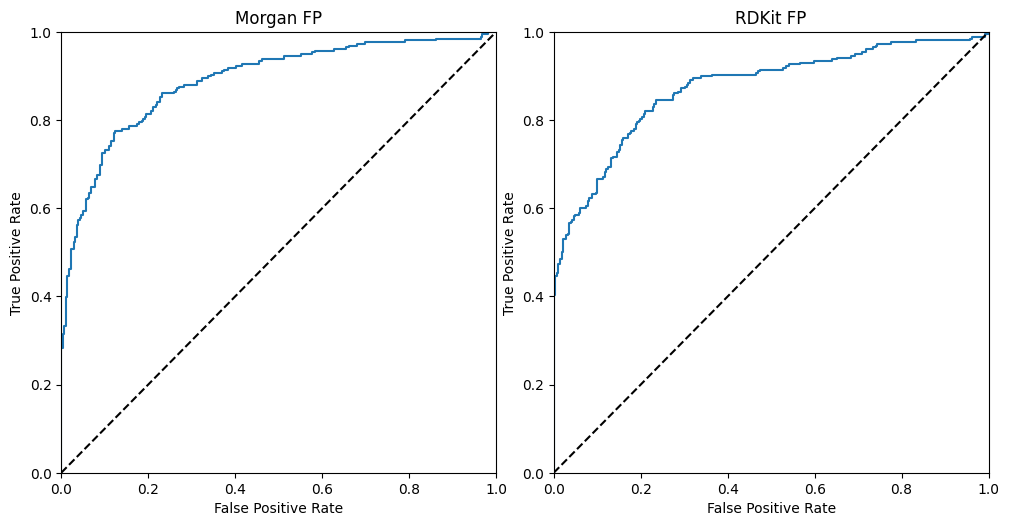

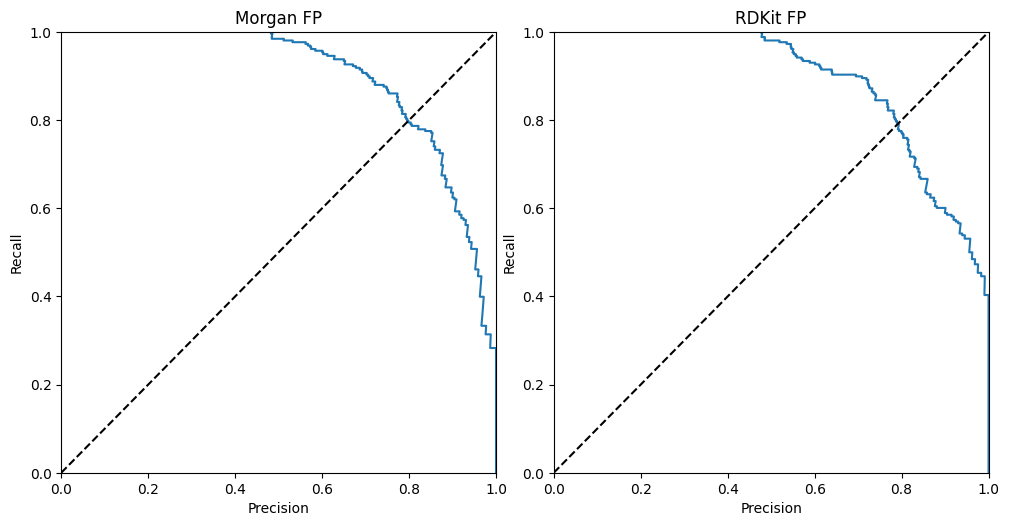

In [52]:
rf_morgan_probabilities = [p[1] for p in best_morgan_treemodel.predict_proba(list(testdata['Morgan2FP']))]
rf_rd_probabilities = [p[1] for p in best_rd_treemodel.predict_proba(list(testdata['RDKit7FP']))]

figure,(ax1,ax2) = plt.subplots(1,2)
figure.set_size_inches(10,5)
figure.tight_layout()

createROCPlot(ax1,testdata['Solubility'],rf_morgan_probabilities,'Morgan FP')
createROCPlot(ax2,testdata['Solubility'],rf_rd_probabilities,'RDKit FP')

figure,(ax1,ax2) = plt.subplots(1,2)
figure.set_size_inches(10,5)
figure.tight_layout()

createPRPlot(ax1,testdata['Solubility'],rf_morgan_probabilities,'Morgan FP')
createPRPlot(ax2,testdata['Solubility'],rf_rd_probabilities,'RDKit FP')

### Similarity Map visualizations

Riniker, S. & Landrum, G. A. "Similarity maps - a visualization strategy for molecular fingerprints and machine-learning methods." Journal of Cheminformatics 5:43 (2013), DOI: http://dx.doi.org/10.1186/1758-2946-5-43

Similarity maps offer a way to visualize which atoms of a molecule contributed in what way to the prediction by a model. Basically, this is achieved by creating a modified feature vector (in this case the binary fingerprint) as it would look like if a specified atom would not be present. Then, the quantitative change of the model prediction between the original fingerprint and the modified fingerprint is computed and regarded as the contribution of the toggled atom to the prediction.

Some things that should be kept in mind:
1. It is a local, atom-wise prediction contribution that is restricted to what kind of effects that atom can have on the features. One important implication is that structural contributions (functional groups, scaffolds,...) can only be recognised if these are present in the fingerprint patterns. This is especially relevant for long-range spatial arrangements.

2. A positive atom-contribution means that removing the atom would give a lower prediction, which means, in the case of probabilities, a lower probability of the examined class.

In [23]:
from rdkit.Chem.Draw import SimilarityMaps, rdMolDraw2D
from IPython.display import HTML, display

In [ ]:
def predFunc(fp,model):
  a = np.zeros(len(fp))
  try:
    DataStructs.ConvertToNumpyArray(fp,a)
  except:
    return None
  #print(model.predict_proba(a.reshape(1, -1)))
  return model.predict_proba(a.reshape(1, -1))[0][-1]

def colorMap(c):
    _ = (np.sign(c)*(np.sqrt(np.abs(c)))+1.0)/2.0
    return cm.PiYG(_)

def showMorgan2SimilarityMap(dataRow, model):
    mol = dataRow['Molecule']
    weights = SimilarityMaps.GetAtomicWeightsForModel(mol,lambda mol,atomId: SimilarityMaps.GetMorganFingerprint(mol,atomId,radius=2, fpType='bv', nBits=2048),lambda x: predFunc(x, morgan_bnb) )
    mc = rdMolDraw2D.PrepareMolForDrawing(mol, kekulize=True)
    drawer = rdMolDraw2D.MolDraw2DSVG(300,300)
    drawer.DrawMolecule(mc,highlightAtoms=[i for i in range(len(weights))],
                        highlightAtomColors=dict([(i,colorMap(weights[i])) for i in range(len(weights))]),
                        highlightAtomRadii=dict([(i,0.5) for i in range(len(weights))]),
                        highlightBonds=[],
                        legend='Solubility: {0}, Prob(Solubility 1): {1}'.format(dataRow['Solubility'],
                                                                       model.predict_proba(dataRow['Morgan2FP'].reshape(1, -1))[0][-1]))
    drawer.FinishDrawing()
    text = drawer.GetDrawingText().replace('svg:','')
    return HTML('<html><hr><h4>Morgan2 Fingerprint: SRI Number {0}</h4>{1}</html>'.format(dataRow['SRI Number'],text))

def showRDKit7SimilarityMap(dataRow, model):
    mol = dataRow['Molecule']
    weights = SimilarityMaps.GetAtomicWeightsForModel(mol,lambda mol,atomId: SimilarityMaps.GetRDKFingerprint(mol,atomId,maxPath=7, fpType='bv', nBits=2048),lambda x: predFunc(x, rd_bnb) )
    mc = rdMolDraw2D.PrepareMolForDrawing(mol, kekulize=True)
    drawer = rdMolDraw2D.MolDraw2DSVG(300,300)
    drawer.DrawMolecule(mc,highlightAtoms=[i for i in range(len(weights))],
                        highlightAtomColors=dict([(i,colorMap(weights[i])) for i in range(len(weights))]),
                        highlightAtomRadii=dict([(i,0.5) for i in range(len(weights))]),
                        highlightBonds=[],
                        legend='Solubility: {0}, Prob(Solubility 1): {1}'.format(dataRow['Solubility'],
                                                                       model.predict_proba(dataRow['RDKit7FP'].reshape(1, -1))[0][-1]))
    drawer.FinishDrawing()
    text = drawer.GetDrawingText().replace('svg:','')
    return HTML('<html><hr><h4>RDKit Fingerprint: SRI Number {0}</h4>{1}</html>'.format(dataRow['SRI Number'],text))

ID = 439
display(HTML(testdata.iloc[[ID]].to_html()))
display(HTML('<h3>Bernoulli Naive Bayes</h3>'))
display(showMorgan2SimilarityMap(testdata.iloc[ID], morgan_bnb))
display(showRDKit7SimilarityMap(testdata.iloc[ID], rd_bnb))

display(HTML('<h3>Optimized Random Forest</h3>'))
display(showMorgan2SimilarityMap(testdata.iloc[ID], best_morgan_treemodel))
display(showRDKit7SimilarityMap(testdata.iloc[ID], best_rd_treemodel))